# Clustering and Classification of Glitches

Many sources can produce noise that obscures or attenuates true gravitational wave (GW) signals. When interferometers detect these noises with different intensities than usual, points in the frequency-time window (called triggers) appear. A set of points in a short observation time window are glitches, and our goal is to classify them. The clustering process involves taking a set of triggers and representing it as just one glitch and this is important because each source produces its own type of glitche, so classifying them makes it easier to identify their origin.

This work will use some functions and ideas from **Francesco Di Renzo** tutorial, available at: **https://drive.google.com/drive/u/0/folders/1s_HT3qvLBzIRA8VYxifLB4Pk-D9xdL20**. To access the Cascina server (Virgo) you need to be logged into Virgo account. The necessary steps is brief comment in this characterization tutorial: **https://drive.google.com/drive/u/0/folders/1s_HT3qvLBzIRA8VYxifLB4Pk-D9xdL20** and are important because some functions only work inside this server.

In [1]:
# Importação
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.filterwarnings("ignore", message="Pandas requires version")

import os
import ast
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from datetime import datetime, timedelta
from gwpy.time import to_gps
from gwpy.table import EventTable
from astropy.table import unique as at_unique
from astropy.units import  Unit, dimensionless_unscaled
from gwpy.timeseries import TimeSeries
from gwpy.segments import DataQualityFlag
from virgotools import getChannel

### 1 Functions and Utilities 

The triggers are cataloged within several files. The following function **find_trigger_files()** is a routine to search for trigger files (from Omicron) within a detector's data directory. The parameters are as follow:

* **ch**: data channel, used to build the folders path.
* **start** and **end**: are beginning and end of time  in GPStime
* **trigpath**: is the path where the triggers files are (by default: /data/*/omicron/)
* **ext**: is just the extension of files that we wanted (by default: .root)

In [2]:
#Encontrar os dados
def find_trigger_files(ch, start, end, trigpath="/data/*/omicron/", ext="root"):
    allfiles = glob(os.path.join(trigpath, "{}/{}_OMICRON".format(*ch.split(":")), "**", f"*.{ext}"), recursive=True)
    if not allfiles:
        print(f"Nenhum arquivo encontrado no caminho {trigpath}")
        return []
    allstart, alldur = np.array([f.rstrip(f".{ext}").split("-")[-2:] for f in allfiles]).astype(int).T
    try:
        rightfiles = np.asarray(allfiles)[(allstart + alldur > start) & (end > allstart)]
    except TypeError:
        print(f"Nenhum arquivo relevante encontrado entre {start} e {end}")
        return []
    return rightfiles

It is worth noting that we have a lot of channels that it is possible to access, and they contain information about a lot of features of interferometers, like temperature, operating time or GWs signals, for exemple. Now lets see the files that are in the gravitational channel of Virgo interferometer **V1:Hrec_hoft_16384Hz**, in the beggining of O4a run:

In [40]:
start = to_gps("2024-05-24 16:00").gpsSeconds
end = to_gps("2024-05-29 12:00").gpsSeconds

In [41]:
trigfiles = find_trigger_files("V1:Hrec_hoft_16384Hz", start, end)

In [42]:
trigfiles

array(['/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14006/V1-Hrec_hoft_16384Hz_OMICRON-1400600086-100212.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14007/V1-Hrec_hoft_16384Hz_OMICRON-1400700298-99904.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14008/V1-Hrec_hoft_16384Hz_OMICRON-1400800202-99904.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14009/V1-Hrec_hoft_16384Hz_OMICRON-1400900106-99895.root',
       '/data/archive/omicron/V1/Hrec_hoft_16384Hz_OMICRON/14010/V1-Hrec_hoft_16384Hz_OMICRON-1401000001-100189.root'],
      dtype='<U109')

We have a lot of data separated into these five files. Lets turn the **first one** into a table:

In [48]:
from gwpy.table import EventTable

gltab = EventTable.read(trigfiles[0].tolist(), treename='triggers;1', nproc=3)
gltab.sort("time")
print(f"{len(gltab)} triggers have been found")

767621 triggers have been found


In [49]:
gltab

time,frequency,q,snr,tstart,tend,fstart,fend,amplitude,phase,tstart_us
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
1400600092.944336,1496.3695261555615,38.073078774317565,5.333692030782796,1400600092.943359,1400600092.945313,1476.2350592320633,1516.7786083957453,1.8035238480425022e-22,-1.3227672768757988,943359
1400600092.944336,1537.4660514489544,38.073078774317565,5.3561994577565635,1400600092.943359,1400600092.945313,1516.7786083957453,1558.4356518965983,1.873364750617949e-22,1.4188686327571292,943359
1400600094.9375,40.61665305221255,72.47796636776955,5.112796582070696,1400600094.875,1400600095.0,40.32883760932051,40.90652255205435,8.179356344720786e-23,-0.9878411641768023,875000
1400600095.0625,40.61665305221255,72.47796636776955,5.09803107819023,1400600095.0,1400600095.125,40.32883760932051,40.90652255205435,8.155734767779663e-23,-0.9844473857759105,0
1400600103.131103,1484.119924161413,10.506111217615068,5.74462413739907,1400600103.130859,1400600103.131348,1415.0117901675303,1556.6032485369612,1.9389315448064682e-22,-2.5303353681221816,130859
1400600103.131103,1349.1216806111363,10.506111217615068,5.408535506550351,1400600103.130859,1400600103.131348,1286.2997479897485,1415.0117901675303,1.6829217711551428e-22,1.9279785387968262,130859
...,...,...,...,...,...,...,...,...,...,...
1400700284.041504,1027.5492200215158,19.999999999999996,5.15394753818052,1400700284.041015,1400700284.041993,1001.6420682614987,1054.1264519764286,1.2239804068286379e-22,0.17339651105612294,41016
1400700287.030273,322.68814629298936,10.506111217615068,5.134910247444668,1400700287.029297,1400700287.03125,307.6621532521276,338.4479977707028,5.512611023307733e-23,0.34981780161346115,29297


Each line in this output represents one trigger and its  characteristics, such as frequency, **q** value, **snr** value or even its small punctual time interval **fstart-fend** (perhaps used for error calculations). The **q** value measures the ratio between center frequency and bandwidth and indicates whether the signal is short or long in time, while the **SNR** measures signal strength relative to noise.

If we plot the SNR occurrence, we will see that **most of our data have low SNR values**. This happens because the LIGO/Virgo pipelines (Omicron, PyCBC, GstLAL, etc.) doesn't yet know whether that's noise or a real gravitational wave, it just notes the timing and characteristics of any excess energy that stands out from the background noise. The most of the signals that appear are statistical fluctuations of these noise, like thermal, seismic, electronic vibrations, etc. These random fluctuations generate small energy spikes: low SNR triggers. **~ Note that the vertical scale is logarithmic!**

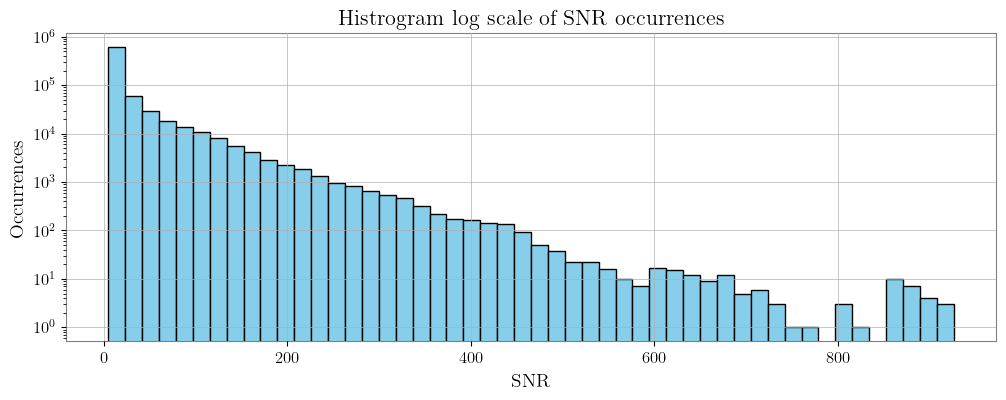

In [50]:
import matplotlib.pyplot as plt

snrs = gltab['snr']

plt.figure(figsize = (12, 4))
plt.hist(snrs, bins = 50, color = 'skyblue', edgecolor = 'black')

plt.title('Histrogram log scale of SNR occurrences')
plt.ylabel('Occurrences')
plt.xlabel('SNR')
plt.yscale('log')
plt.show()

Furthermore we can see the Q histogram. The parameter Q is the quality factor of the Q-transform, and it measures the relationship between time and frequency of an analysis window: central frequency per bandwidth: $f_{0}/ \Delta f$. 

**Low Q values** means short time and wide frequency windows $\Rightarrow$ sensitive to short transients

**High Q values** means long time and narrow frequency windows $\Rightarrow$ sensitive to more sinusoidal, long-duration signals.

**But why do only a few discrete values ​​of Q appear (See graph below)?** This is because of the algorithm. Omicron and other Q-transform based pipelines does not sweep Q continuously, but uses a discrete set of predefined values. The software calculates spectrograms with only a few fixed Q values, and looks for energy peaks in each of them, thus each detected trigger “inherits” the Q of the analysis layer in which it was found. Even among the allowed values, you'll find that certain Qs dominate. This is because the nature of the noise in the detector tends to produce glitches with typical durations and frequencies and these fit best within certain Q windows. Furthermore, the pipeline may be tuned to give higher resolution in some Q ranges.

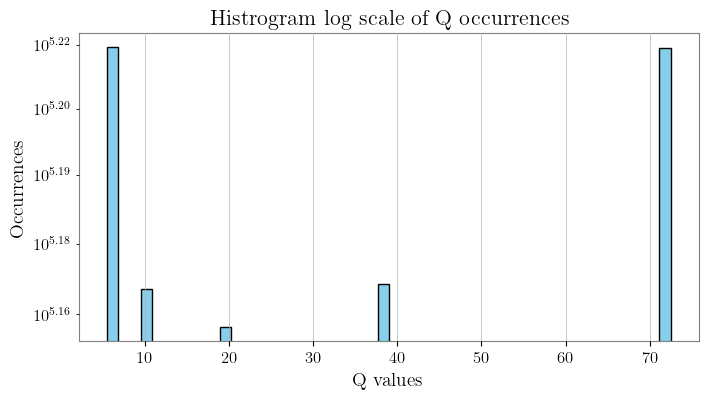

In [51]:
qs = gltab['q']

plt.figure(figsize = (8, 4))
plt.hist(qs, bins = 50, color = 'skyblue', edgecolor = 'black')

plt.title('Histrogram log scale of Q occurrences')
plt.ylabel('Occurrences')
plt.xlabel('Q values')
plt.yscale('log')
plt.show()

The following function **clusterize_triggers()** is to identify sets of triggers and turn into a unique glitch, where the representative point is the one with the largest signal-to-noise ratio (SNR). This function will receive the previous **table** that we choose and the **window** in seconds. We calculate the time between the end of one trigger and the start of the next (from **delta_t**). If this interval is less than or equal to the window value, the triggers are considered to be from the same cluster.

In [8]:
#Processo de clusterização
def clusterize_triggers(table, window=0.1):
    if len(table) == 0:
        return EventTable(rows=[])  # retorna tabela vazia se não houver triggers

    table = table.copy()
    table.sort('tstart')

    cluster_ids = np.zeros(len(table), dtype=int)
    cluster_index = 0
    for i in range(1, len(table)):
        delta_t = table[i]['tstart'] - table[i-1]['tend']
        if delta_t <= window:
            cluster_ids[i] = cluster_index
        else:
            cluster_index += 1
            cluster_ids[i] = cluster_index

    table['cluster'] = cluster_ids
    summary_rows = []
    for cl in np.unique(cluster_ids):
        cluster_rows = table[table['cluster'] == cl]
        if len(cluster_rows) == 0:
            continue
        max_idx = np.argmax(cluster_rows['snr'])
        max_row = cluster_rows[max_idx]

        summary_rows.append({
            'cluster': cl,
            'tstart': np.min(cluster_rows['tstart']),
            'tend': np.max(cluster_rows['tend']),
            'fmin': np.min(cluster_rows['fstart']),
            'fmax': np.max(cluster_rows['fend']),
            'time': max_row['time'],
            'frequency': max_row['frequency'],
            'q': max_row['q'],
            'snr': max_row['snr'],
            'phase': max_row['phase']
        })
    return EventTable(rows=summary_rows)

Furthermore, the functions bellow are necessary for calculate the operation time of the interferometer, from data quality channel **chDQ**. This result will be used to find the rate of glitches per time.

In [9]:
#Manipulação de String I
def FrV_to_TS(frV):
    try:
        unit = Unit(frV.unit)
    except Exception:
        unit = dimensionless_unscaled
    return TimeSeries(data=frV.data, t0=frV.gps, sample_rate=frV.fsample, unit=unit, channel=frV.name)
    
#Manipulação de String II
def read2TS(*args, **kwargs):
    with getChannel(*args, **kwargs) as frv:
        return FrV_to_TS(frv)
        
# Função para calcular tempo ativo
def dq_active_seconds(chDQ, state_val, start_dt, end_dt, label="Low Noise"):
    """Retorna (total_active_seconds, DQflag) no intervalo [start_dt, end_dt]."""
    start = to_gps(start_dt).gpsSeconds if hasattr(to_gps(start_dt), "gpsSeconds") else to_gps(start_dt)
    end   = to_gps(end_dt).gpsSeconds   if hasattr(to_gps(end_dt), "gpsSeconds")   else to_gps(end_dt)

    DQTS = read2TS("trend", chDQ, start, end)
    sTS = DQTS >= state_val
    DQ = sTS.to_dqflag(label=label)

    total_active = float(sum(seg[1] - seg[0] for seg in DQ.active))  # segundos
    return total_active, DQ

### 2 Clustering Proccess

Now lets start the key part of this code. **First** of all we choose the gravitational and data-quality channels. Furthermore the **state_val** value, where indicates which operating condition of the interferometer you want to analyze ~ such as “locked”, “low noise”, “unlocked”, etc. The value 135corresponds to Low Noise 3.

In [10]:
#Janela de operação

ch = 'V1:Hrec_hoft_16384Hz'
chDQ = 'V1:META_ITF_LOCK_index'
state_val = 135  # low-noise 3

**Second**, we will choose the SNR intervals we wanted ~ around 8 is a good values (see this histograms analysis at **this reference**), and the operation time of the detector, where in our case we will take the start of race O4a:

In [11]:
run_start_day = datetime(2024, 6, 1, 23, 59, 59)
run_end_day   = datetime(2024, 6, 10, 23, 59, 59)

snr_thresholds = [6.5, 10] #SNR_cut
cluster_window = 0.1  # Janela de clusterização (segundos)

**Third**: run the code. Here we will take the operation time of the detector, see if we have files in this channel, cluster triggers into glitches and apply the filters in SNR. The computational process is slow, so we only took 10 days close to the beginning of O4 run.

In [13]:
current_day = run_start_day

days_per_part = 20
part_number = 1
monthly_results = []

while current_day <= run_end_day:
    day_start = datetime(current_day.year, current_day.month, current_day.day, 0, 0, 0)
    day_end   = datetime(current_day.year, current_day.month, current_day.day, 23, 59, 59)
    print(f"Processando dia: {current_day.date()}")

    # --- take the operation time of the detector ---
    try:
        total_active_seconds, DQ = dq_active_seconds(chDQ, state_val, day_start, day_end)
    except Exception as e:
        print(f"  Falha ao obter DQ ({current_day.date()}): {e}")
        total_active_seconds = 0.0
    total_active_hours = total_active_seconds / 3600.0

    # --- see if we have files in this channel ---
    gps_start = to_gps(day_start)
    gps_end   = to_gps(day_end)
    trigfiles = find_trigger_files(ch, gps_start, gps_end)
    if len(trigfiles) == 0:
        print(f"Nenhum arquivo encontrado para o dia {day_start.date()}")
        gltab = EventTable(rows=[])
    else:
        gltab = EventTable.read([trigfiles[0]], treename='triggers;1', nproc=1)
        gltab.sort("time")
        if len(gltab) > 0:
            gltab = at_unique(gltab)
            
    print(f'{gltab}\n\n')

    # --- cluster triggers into glitches ---
    clustered = clusterize_triggers(gltab, window=cluster_window) if len(gltab) > 0 else EventTable(rows=[])

    print(f'{clustered}\n\n')
    
    # --- apply the filters in SNR ---
    counts_nonclustered = {snr: int(np.sum(gltab['snr'] > snr)) if len(gltab) > 0 else 0 for snr in snr_thresholds}
    counts_clustered   = {snr: int(np.sum(clustered['snr'] > snr)) if len(clustered) > 0 else 0 for snr in snr_thresholds}

    monthly_results.append({
        "date": current_day.date(),
        "n_triggers_nonclustered": int(len(gltab)),
        "n_triggers_clustered": int(len(clustered)),
        "counts_nonclustered": counts_nonclustered,
        "counts_clustered": counts_clustered,
        "total_active_seconds": total_active_seconds
    })

    # If we wanted save this data in **.csv** files, rode this code:
    
    # --- salvar parcial ---
    if len(monthly_results) % days_per_part == 0:
        fname = f"O4b_part{part_number}.npy"
        np.save(fname, monthly_results)
        print(f"=== Resultados parciais salvos em {fname} ===\n")
        part_number += 1
        monthly_results = []

    current_day += timedelta(days=1)

Processando dia: 2024-06-01
       time           frequency      ...        phase         tstart_us
----------------- ------------------ ... -------------------- ---------
1401200103.140625 163.69527534632903 ... -0.32185516911079454    125000
1401200103.164062 162.24492036535204 ...   0.7912689800534594    156250
1401200103.171875 163.69527534632903 ... -0.30988881448842764    156250
1401200103.171875 166.04010602754826 ...  -0.8766177949806632    156250
1401200103.203125 163.69527534632903 ...  -0.2518128676737233    187500
1401200103.203125 166.04010602754826 ...    -1.13318650074246    187500
1401200116.871093  718.5041813754985 ...   -1.537802206472808    867188
              ...                ... ...                  ...       ...
1401299987.226074 1027.5492200215158 ...   2.1778846373452865    225586
 1401299987.22705 1027.5492200215158 ...   2.1650150146293905    226563
1401299987.228027 1027.5492200215158 ...   2.1699818303791045    227539
1401299988.436035  258.0391581837544

The next proccess is save and combine all parts into one. Here some things you need to know: in the data, some times we have days without any observation of triggers. This doesn't mean the detector wasn't working, but it could indicate a number of different situations.

The main reasons for having days or periods without triggers: 

* **The detector was offline (no valid data)** - Each interferometer (H1, L1 or V1) has periods called science segments, when it is “locked” and actually measuring length variations. Outside of these periods, he may be shut down for maintenance, performing calibration or simply “unlocked”, i.e., outside the stable interferometric regime. At these times, no physical data is written to the gravity channel, so no trigger can be produced.
* **Data available, but flagged as bad (Data Quality Flags)** - Even if the detector was on, there are periods marked by intense instrumental noise, saturation, or other problems. These ranges receive data quality flags, and the trigger pipeline simply ignores this data to avoid generating false triggers.
* **Maintenance operations or engineering executions** - During calibrations, testing or engineering, the channels are reset, and the main gravitational channel (V1:Hrec_hoft_16384Hz in our case) may not contain the physical strain, but rather artificial injected signals. These periods are marked and excluded from automatic pipelines, again resulting in no triggers.

So, the function **nonzero_counts()** will just remove data with "0 values". This keeps only rows that have non-null triggers, i.e. days/detectors with actual activity recorded.

In [21]:
# --- salvar última parte ---
if len(monthly_results) > 0:
    fname = f"O4b_part{part_number}.npy"
    np.save(fname, monthly_results)
    print(f"=== Última parte salva em {fname} ===\n")

# ---------------- Combinar todas as partes em CSV final ----------------
all_parts = []
part_number = 1
while True:
    fname = f"O4b_part{part_number}.npy"
    if not os.path.exists(fname):
        break
    arr = np.load(fname, allow_pickle=True)
    all_parts.extend(arr)
    part_number += 1

# converter para DataFrame
df = pd.DataFrame(all_parts)

# remover linhas com counts zero
def nonzero_counts(row):
    nc = row.get('counts_nonclustered', {}) if isinstance(row.get('counts_nonclustered', {}), dict) else {}
    c  = row.get('counts_clustered', {}) if isinstance(row.get('counts_clustered', {}), dict) else {}
    return any(v > 0 for v in nc.values()) or any(v > 0 for v in c.values())

df = df[df.apply(nonzero_counts, axis=1)]

# salvar CSV final
df.to_csv("O4b_full.csv", index=False)
print("Arquivo final salvo: O4b_full.csv")

=== Última parte salva em O4b_part2.npy ===

Arquivo final salvo: O4b_full.csv


The next step is just perfumery to convert string dictionaries into python dictionaries. 

First, reads a CSV file with trigger count results (clustered and non-clustered). Apply the function **safe_eval()** on the data: Dictionaries are often saved in CSV as strings and this function is just to convert this string back to a real dictionary **dict**, If it fails, it returns an empty dictionary **{}**. 

Second, sum the values ​​of certain SNR keys to obtain totals. We gets the value associated with SNR key (6.5, for example) in the dictionary. If it does not exist, it returns 0, otherwise sum these values ​​for all rows of the DataFrame.

In [22]:
# -------------------------
# Função de leitura
# -------------------------
def load_and_sum(filename):
    
    df = pd.read_csv(filename)

    # Converte os dicionários salvos como string em dict
    def safe_eval(x):
        if isinstance(x, str):
            try:
                return ast.literal_eval(x)
            except Exception:
                return {}
        return x if isinstance(x, dict) else {}

    df['counts_nonclustered'] = df['counts_nonclustered'].apply(safe_eval)
    df['counts_clustered']    = df['counts_clustered'].apply(safe_eval)

    totals = {
        "Total_Counts_NonClustered_6.5": df['counts_nonclustered'].apply(lambda d: d.get(6.5, 0)).sum(),
        "Total_Counts_NonClustered_10": df['counts_nonclustered'].apply(lambda d: d.get(10, 0)).sum(),
        "Total_Counts_Clustered_6.5": df['counts_clustered'].apply(lambda d: d.get(6.5, 0)).sum(),
        "Total_Counts_Clustered_10": df['counts_clustered'].apply(lambda d: d.get(10, 0)).sum(),
        "Total_Time": df['total_active_seconds'].sum() / 3600  # converte para horas
    }
    return totals

# aplica nos dois arquivos
'''res_a = load_and_sum("O4a_full_clean.csv")'''
res_b = load_and_sum("O4b_full_clean.csv")

'''print("=== O4a ===")
for k, v in res_a.items():
    print(f"{k}: {v}")'''

print("\n=== O4b ===")
for k, v in res_b.items():
    print(f"{k}: {v}")


=== O4b ===
Total_Counts_NonClustered_6.5: 6716706
Total_Counts_NonClustered_10: 4234767
Total_Counts_Clustered_6.5: 6531
Total_Counts_Clustered_10: 1028
Total_Time: 215.6822222222222


In [30]:
nonclust6_5, nonclust_10, clus6_5, clust10, totaltime = res_b.values()

Now we can plot our results to see more clearly. If you calculate, our glitches per hour above SNR 6.5 is ~ 30.3 and above SNR 10 is ~ 4.8. But we choose time window between 24 to 29 of mai/2024. If we take in account most of the O4 run (~ 02/06/2023 to 20/07/2024), these values are 119 and 21.3, respectively. Lets plot the glitches per hour for each interferometer consider all run:

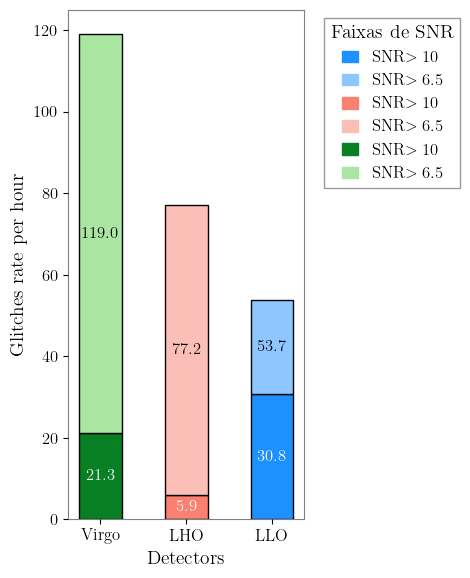

In [57]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Ajuste global de estilo e fonte tipo LaTeX
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
    'text.usetex': True,
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Dados
detectors = ['Virgo', 'LHO', 'LLO']

totals = [119.0, 77.2, 53.7]
cuts   = [21.3, 5.9, 30.8]

colors_dark = ['#087F23', '#fa8072', '#1e90ff']   # SNR > 10
colors_light = ['#A8E6A1', '#fcbfb8', '#8ec7ff']  # 6.5 < SNR < 10

fig, ax = plt.subplots(figsize=(5, 6))

bar_width = 0.5
x = np.arange(len(detectors))

for i, (total, cut, c_dark, c_light) in enumerate(zip(totals, cuts, colors_dark, colors_light)):
    # Parte escura (SNR > 10)
    ax.bar(x[i], cut, width=bar_width, color=c_dark, edgecolor='black')
    ax.text(x[i], cut/2, f'{cut:.1f}', ha='center', va='center', 
            color='white', fontsize=12, fontweight='bold')
    
    # Parte clara (6.5 < SNR < 10)
    remainder = total - cut
    ax.bar(x[i], remainder, bottom=cut, width=bar_width, color=c_light, edgecolor='black')
    ax.text(x[i], cut + remainder/2, f'{total:.1f}', ha='center', va='center',
            color='black', fontsize=12, fontweight='bold')

# Legenda
legend_patches = [
    Patch(color='#1e90ff', label=r'SNR$>10$'),
    Patch(color='#8ec7ff', label=r'SNR$>6.5$'),
    Patch(color='#fa8072', label=r'SNR$>10$'),
    Patch(color='#fcbfb8', label=r'SNR$>6.5$'),
    Patch(color='#087F23', label=r'SNR$>10$'),
    Patch(color='#A8E6A1', label=r'SNR$>6.5$')
]
ax.legend(handles=legend_patches, title='Faixas de SNR', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticks(x)
ax.set_xticklabels(detectors)
ax.set_xlabel('Detectors')
ax.set_ylabel('Glitches rate per hour')
'''axs[0].set_title("O4a")'''
plt.grid(None)
plt.tight_layout()
'''plt.savefig('glitches_rate_per_hour_4a.pdf')'''
plt.show()
